In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using MuJoCo
using CairoMakie
using LinearAlgebra
using MatrixEquations: ared
using MuJoCo
import MuJoCo as MJ

  Activating project at `~/16745_Unitree_G1_Goal_Kicking_Julia/src`


## Initialize Mujoco


In [2]:
init_visualiser()
isplot = true
model, data = MuJoCo.sample_model_and_data()
const keyframe = 2 # Stand on one leg is the second keyframe.
resetkey!(model, data, keyframe)

┌ Warning: The visualiser for MuJoCo.jl is designed to run multi-threaded, but the current Julia session was started with only one thread. Degraded performance will occur. To enable multi-threading, set JULIA_NUM_THREADS to a value greater than 1 before starting Julia.
└ @ VisualiserExt /home/genisis/.julia/packages/MuJoCo/564rW/ext/VisualiserExt/VisualiserExt.jl:76


## Get control set-point

We want to torque required to hold the humanoid in this position. Just using inverse dynamics won't work yet - there's an unphysical vertical contact force with the ground we want to remove first. Here's a hacky approach.

In [3]:

heights = LinRange(-0.001, 0.001, 2001)
u_vert = zeros(length(heights))
for k in eachindex(heights)

    # Set model in position and assume qacc == 0
    resetkey!(model, data, keyframe)
    forward!(model, data)
    data.qacc .= 0

    # Offset the height and check required vertical forces
    data.qpos[3] += heights[k]
    mj_inverse(model, data)
    u_vert[k] = data.qfrc_inverse[3] # 3 -> z-force
end

Find height corresponding to minimum ficticous force (best offset) and plot the relationship just to see - compare force to weight of humanoid


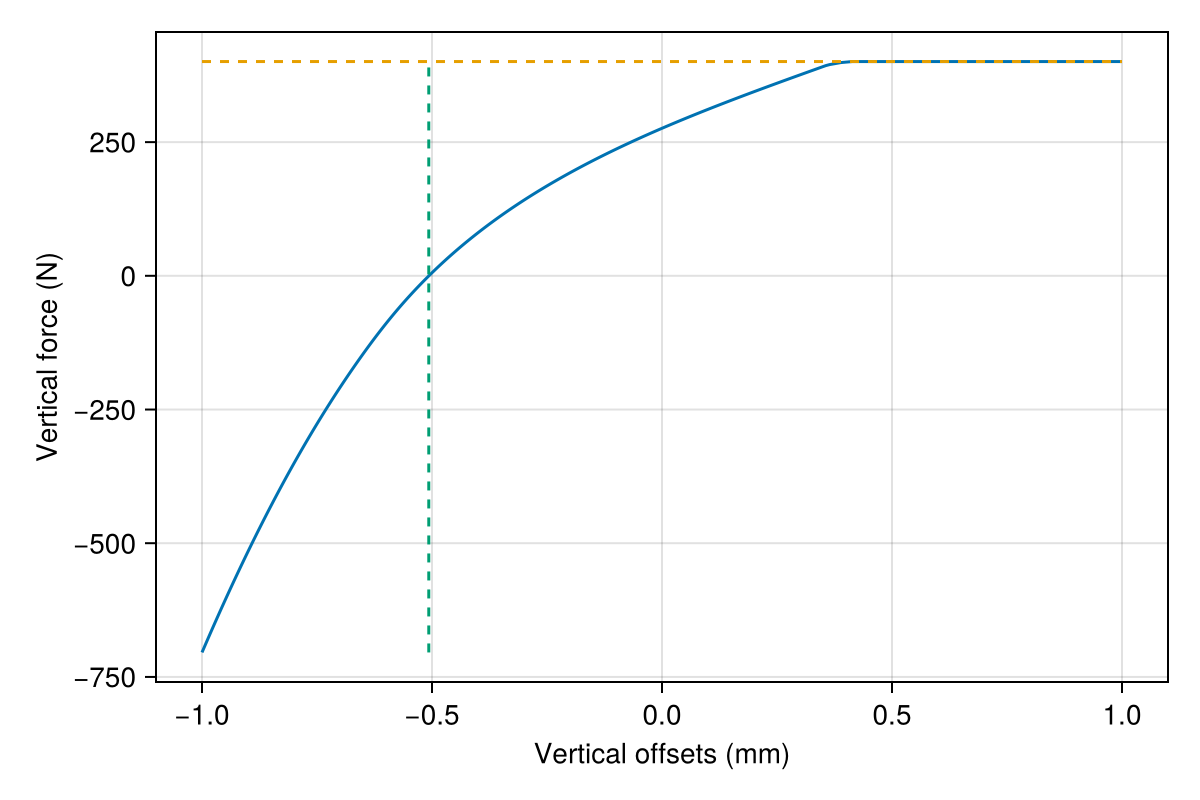

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/genisis/.julia/packages/Makie/ux0Te/src/scenes.jl:238


CairoMakie.Screen{IMAGE}


In [4]:
height = heights[argmin(abs.(u_vert))]
weight = sum(model.body_mass) * norm(model.opt.gravity)

fig = Figure(resolution=(600,400))
ax = Axis(fig[1,1], xlabel="Vertical offsets (mm)", ylabel="Vertical force (N)")
lines!(ax, heights*1000, u_vert)
lines!(ax, heights*1000, weight*ones(length(heights)), linestyle=:dash)
lines!(ax, [height, height]*1000, [minimum(u_vert), maximum(u_vert)], linestyle=:dash)
isplot && display(fig)

We'll use the best-choice offset to get our required ID forces and save q0

In [5]:
resetkey!(model, data, keyframe)
forward!(model, data)
data.qacc .= 0
data.qpos[3] += height
qpos0 = vec(copy(data.qpos))
mj_inverse(model, data)
qfrc0 = vec(copy(data.qfrc_inverse))
println("Desired forces qfrc0 acquired")

Desired forces qfrc0 acquired


Need the corresponding control torque (through the actuators)

In [6]:
M_act = data.actuator_moment
ctrl0 = pinv(M_act)' * qfrc0
println("Control set-point ctrl0 acquired")

Control set-point ctrl0 acquired


Double-check (note: this works because the humanoid is fully-actuated!)

In [7]:
data.ctrl .= ctrl0
forward!(model, data)
qfrc_test = vec(copy(data.qfrc_actuator))
println("Desired force meets actual? ", all((qfrc_test .≈ qfrc0)[7:end]))

Desired force meets actual? true


Run the simulation


In [8]:
reset!(model, data)
data.qpos .= qpos0
data.ctrl .= ctrl0

isplot && visualise!(model, data)

 __  __            _        _____       _ _ 
|  \/  |          | |      / ____|     (_) |
| \  / |_   _     | | ___ | |     ___   _| |
| |\/| | | | |_   | |/ _ \| |    / _ \ | | |
| |  | | |_| | |__| | (_) | |___| (_) || | |
|_|  |_|\__,_|\____/ \___/ \_____\___(_) |_|
                                      _/ |  
                                     |__/   

Press "F1" to show the help message.


## LQR Design

In [9]:
# Useful dimensions
nu = model.nu
nv = model.nv

# R-matrix just identity
R = Matrix{Float64}(I, nu, nu)

# Body IDs
torso = MJ.body(model, "torso")
left_foot = MJ.body(model, "foot_left")

# Get Jacobian for torso CoM
reset!(model, data)
data.qpos .= qpos0
forward!(model, data)
jac_com = mj_zeros(3, nv)
mj_jacSubtreeCom(model, data, jac_com, torso.id)

# Get (left) foot Jacobian for balancing
jac_foot = mj_zeros(3, nv)
mj_jacBodyCom(model, data, jac_foot, nothing, left_foot.id)

# Design Q-matrix to balance CoM over foot
jac_diff = jac_com .- jac_foot
Qbalance = jac_diff' * jac_diff

27×27 Matrix{Float64}:
  4.93038e-32   0.0           0.0          …   1.56436e-18  -1.09719e-18
  0.0           4.93038e-32   0.0             -1.42229e-18   6.97275e-21
  0.0           0.0           4.93038e-32      2.05105e-18   6.37879e-19
 -3.44558e-17  -1.70269e-16  -1.74053e-18      0.00374618    0.000720172
  1.6435e-16   -1.68553e-17  -8.26542e-19      0.00566652   -0.00367048
  6.06828e-17  -5.10063e-17  -7.98308e-19  …   0.0033636    -0.00136796
  5.95783e-17  -5.67293e-17   1.65874e-18      0.00359586   -0.0013124
  1.48846e-16  -1.96763e-17   8.28595e-18      0.00563506   -0.00320797
 -2.61589e-17  -1.52332e-16  -1.14466e-17      0.00308823    0.000412496
  1.84487e-18   1.18236e-17  -4.71393e-18     -0.000478646  -0.000100371
  ⋮                                        ⋱   ⋮            
 -8.06097e-17   1.3893e-17    1.58503e-17     -0.00229907    0.0020009
  1.71085e-17  -2.05411e-18   7.53638e-18      0.000915607  -0.000283515
  1.27009e-18   1.10305e-17  -4.6559e-21   …  -

Now we include a cost on joints deviating from the steady-state. Torso already sorted. Left leg should remain rigid. Other joints can move for balance.


In [10]:

# Get indices into relevant sets of joints.
free_dofs = 1:6
body_dofs = 7:nv

# Get all the joints using a list comprehension. We add one to the raw ID to get the Julia 1-based index of the joint.
abdomen_dofs = [jnt.id+1 for jnt in MJ.joints(model) if occursin("abdomen", jnt.name)]
left_leg_dofs = [jnt.id+1 for jnt in MJ.joints(model) if occursin("left", jnt.name) && any(occursin(part, jnt.name) for part in ("hip", "knee", "ankle"))]

balance_dofs = vcat(abdomen_dofs, left_leg_dofs)
other_dofs = setdiff(body_dofs, balance_dofs)

# Cost coefficients
balance_cost       = 1000       # CoM units large, keep it still
balance_joint_cost = 3          # Joints can move a bit and still balance
other_joint_cost   = 0.3        # Other joints can do whatever

# Construct joint Q matrix
Qjoint = Matrix{Float64}(I, nv, nv)
Qjoint[free_dofs, free_dofs] *= 0
Qjoint[balance_dofs, balance_dofs] *= balance_joint_cost
Qjoint[other_dofs, other_dofs] *= other_joint_cost

# Total Q-matrix
Qpos = balance_cost*Qbalance + Qjoint
Q = [Qpos zeros(nv,nv); zeros(nv, 2nv)]  + (1e-10)I # Add ϵI for positive definite Q

# Get A and B matrices from Jacobian
reset!(model, data)
data.ctrl .= ctrl0
data.qpos .= qpos0

A = mj_zeros(2nv, 2nv)
B = mj_zeros(2nv, nu)
ϵ = 1e-6
centred = true
mjd_transitionFD(model, data, ϵ, centred, A, B, nothing, nothing)

# Solve LQR with MatrixEquations.jl (faster than loading ControlSystems.jl)
S = zeros(size(Q,1), size(R,1))
_, _, K, _ = ared(A,B,R,Q,S)

# Write the LQR function
function humanoid_ctrl!(m::Model, d::Data)

    # Get difference in states qpos - qpos0 (this function does quaternion diff)
    Δq = zeros(nv)
    mj_differentiatePos(m, Δq, 1, qpos0, d.qpos)
    Δx = vcat(Δq, data.qvel)

    # Compute controls with LQR
    data.ctrl .= (ctrl0 .- K*Δx)
    return nothing
end

# Initialise the humanoid and visualise
reset!(model, data)
data.qpos .= qpos0
visualise!(model, data, controller=humanoid_ctrl!)

 __  __            _        _____       _ _ 
|  \/  |          | |      / ____|     (_) |
| \  / |_   _     | | ___ | |     ___   _| |
| |\/| | | | |_   | |/ _ \| |    / _ \ | | |
| |  | | |_| | |__| | (_) | |___| (_) || | |
|_|  |_|\__,_|\____/ \___/ \_____\___(_) |_|
                                      _/ |  
                                     |__/   

Press "F1" to show the help message.
